##Tiny NeRF
This is a simplied version of the method presented in *NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis*

[Project Website](http://www.matthewtancik.com/nerf)

[arXiv Paper](https://arxiv.org/abs/2003.08934)

[Full Code](github.com/bmild/nerf)

Components not included in the notebook
*   5D input including view directions
*   Hierarchical Sampling



In [17]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 1.x

import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

In [18]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

# Load Input Images and Poses

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


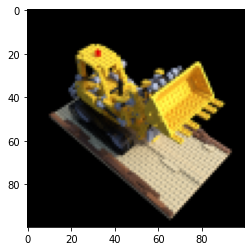

In [28]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal'] # focal is fixed, as 138.88887889922103
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

(100, 100, 100, 3)


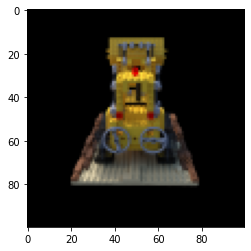

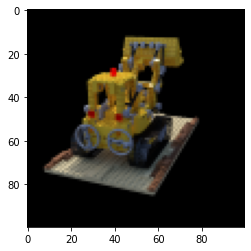

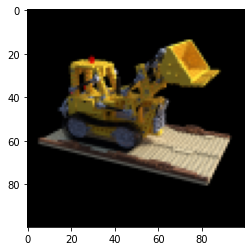

In [20]:
print(images.shape)
for i in range(3):
  plt.imshow(images[i])
  plt.show()

In [22]:
print(data['poses'].shape)
for i in range(0,5):
  print(data['poses'][i])

(106, 4, 4)
[[-9.9990219e-01  4.1922452e-03 -1.3345719e-02 -5.3798322e-02]
 [-1.3988681e-02 -2.9965907e-01  9.5394367e-01  3.8454704e+00]
 [-4.6566129e-10  9.5403719e-01  2.9968831e-01  1.2080823e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
[[-9.3054223e-01  1.1707554e-01 -3.4696460e-01 -1.3986591e+00]
 [-3.6618456e-01 -2.9751042e-01  8.8170075e-01  3.5542498e+00]
 [ 7.4505806e-09  9.4751304e-01  3.1971723e-01  1.2888215e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
[[ 0.44296363  0.3137772  -0.8398375  -3.3854935 ]
 [-0.8965397   0.15503149 -0.4149481  -1.6727095 ]
 [ 0.          0.9367546   0.34998694  1.4108427 ]
 [ 0.          0.          0.          1.        ]]
[[ 7.9563183e-01  5.2092606e-01 -3.0920234e-01 -1.2464346e+00]
 [-6.0578054e-01  6.8418401e-01 -4.0610620e-01 -1.6370665e+00]
 [-1.4901161e-08  5.1041979e-01  8.5992539e-01  3.4664700e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
[[-6.5665424e-01 -2.3678

# Optimize NeRF



In [23]:


def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 6
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()    
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    # 3 * (1 + 2 * L_embed), here 2 refers to sin, cos
    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed)) 
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
    outputs = dense(4, act=None)(outputs)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_rays(H, W, focal, c2w):
    # i and j are both (H, W)
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    # (H, W, 3) make it zero centered and then div by focal
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    # d vector (H, W, 3) direction * c2w
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    # (H, W, 3) make a flat/broadcasted tensor with (H, W, 3) from c2w[:3, -1]
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d



def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    def batchify(fn, chunk=1024*32):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    
    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples) 
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])
    
    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3]) 
    
    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1.-tf.exp(-sigma_a * dists)  
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    
    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2) 
    depth_map = tf.reduce_sum(weights * z_vals, -1) 
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map

Here we optimize the model. We plot a rendered holdout view and its PSNR every 50 iterations.


![](https://wikimedia.org/api/rest_v1/media/math/render/svg/875652c56fc3da38de8b3990d46ed9de9d464125)

This implementation put it in a inverse order

$$PSNR=-10 \cdot ln(\frac{MSE}{MAX^2_I}) = -10 \cdot ln(\frac{MSE}{ln(10)}) $$

About GradientTape in tensorflow eager mode:
https://stackoverflow.com/questions/53953099/what-is-the-purpose-of-the-tensorflow-gradient-tape


0 0.12343859672546387 secs per iter


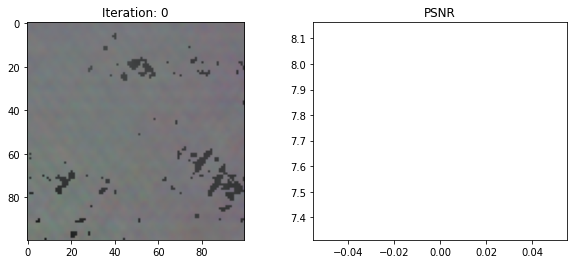

25 0.6888230514526367 secs per iter


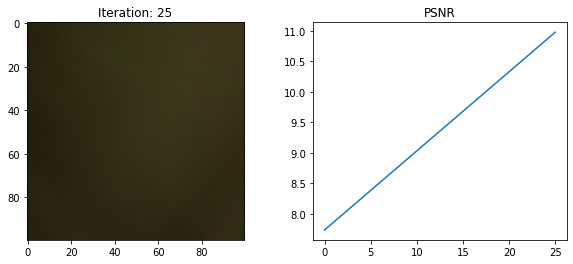

50 0.6918805408477783 secs per iter


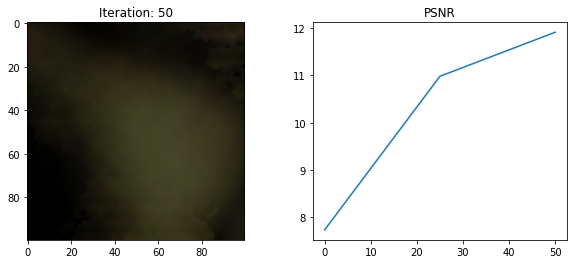

75 0.6792595100402832 secs per iter


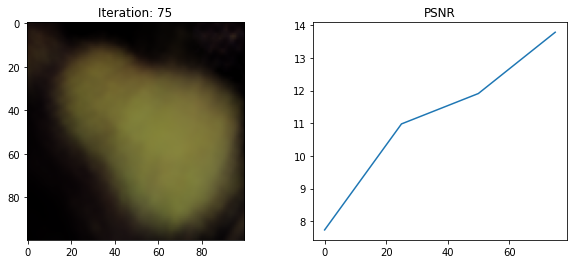

100 0.6921885395050049 secs per iter


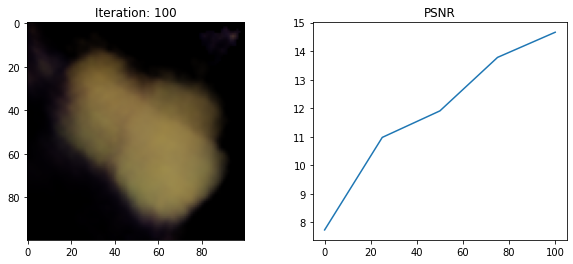

125 0.6882360744476318 secs per iter


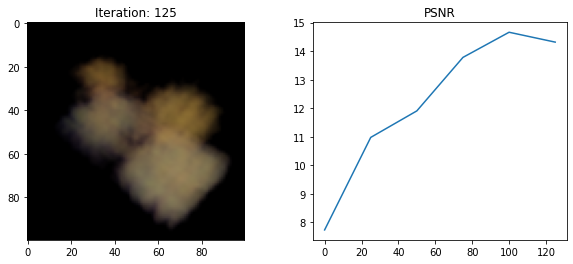

150 0.7039441013336182 secs per iter


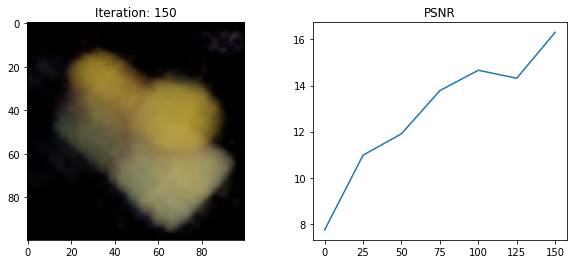

175 0.7230620288848877 secs per iter


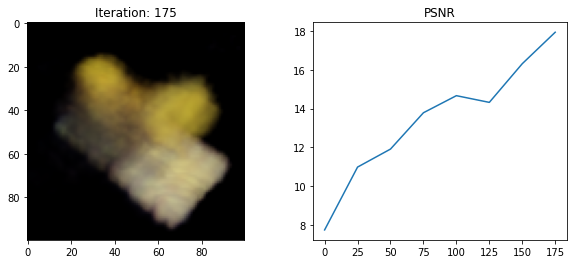

200 0.7271255493164063 secs per iter


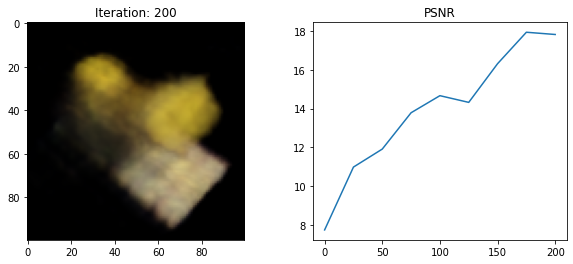

225 0.7141533946990967 secs per iter


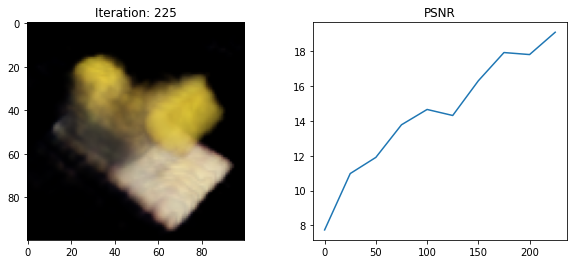

250 0.7150404167175293 secs per iter


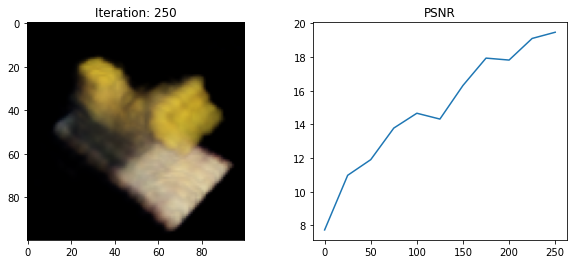

275 0.7191785335540771 secs per iter


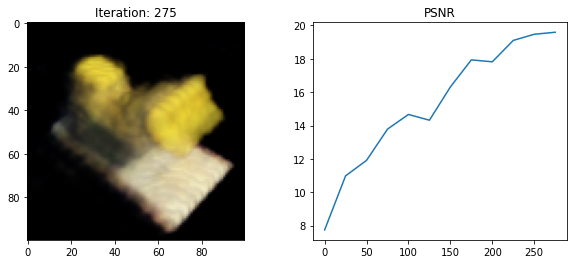

300 0.7212594318389892 secs per iter


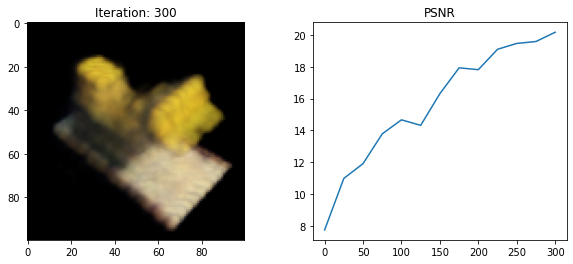

325 0.7195123863220215 secs per iter


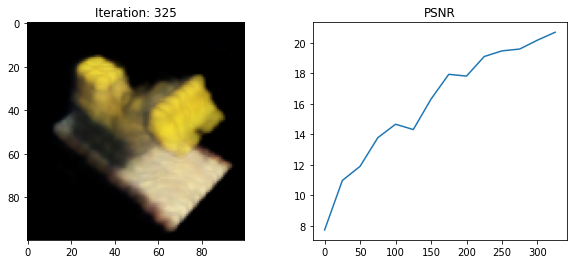

350 0.7186271858215332 secs per iter


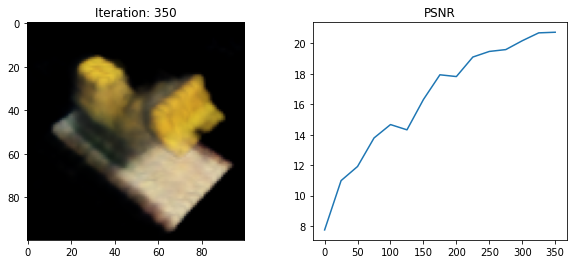

375 0.7194851875305176 secs per iter


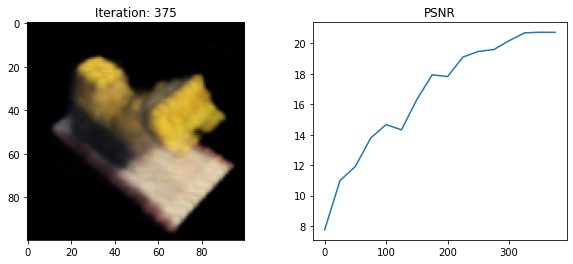

400 0.718037223815918 secs per iter


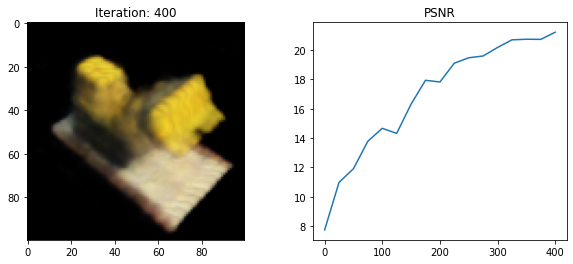

425 0.71944091796875 secs per iter


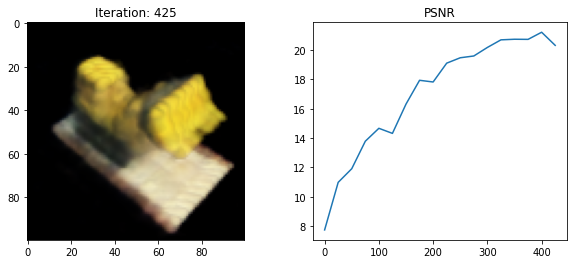

450 0.7205387592315674 secs per iter


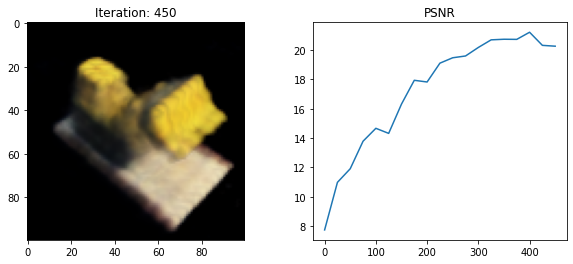

475 0.7201488494873047 secs per iter


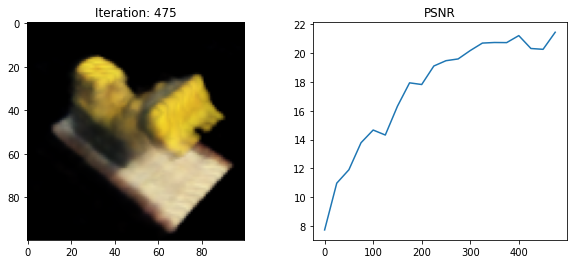

500 0.7216281890869141 secs per iter


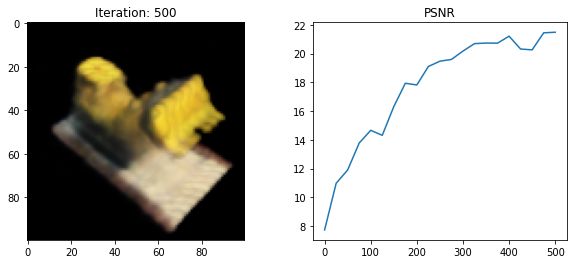

525 0.7200669384002686 secs per iter


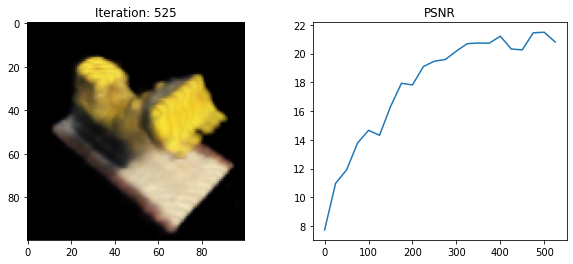

550 0.7190651702880859 secs per iter


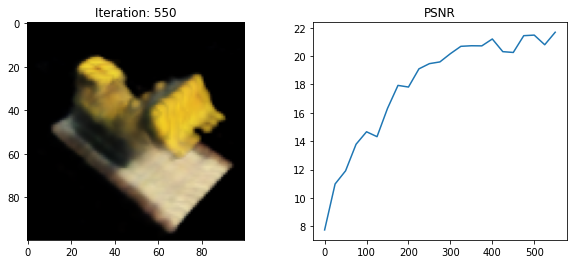

575 0.718566608428955 secs per iter


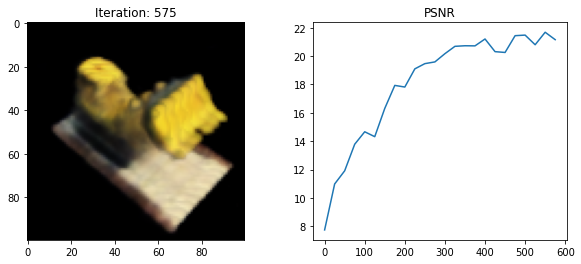

600 0.7160309791564942 secs per iter


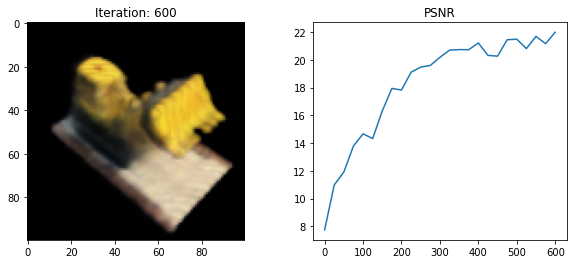

625 0.7208828163146973 secs per iter


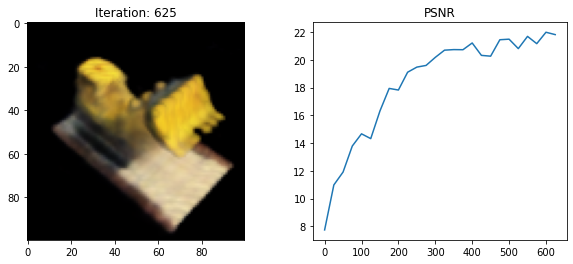

650 0.7174672603607177 secs per iter


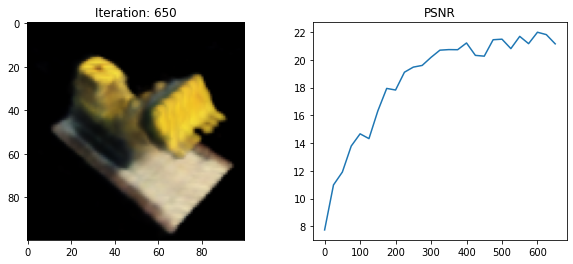

675 0.7172035217285156 secs per iter


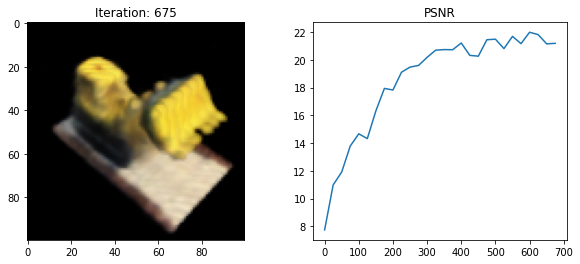

700 0.7171670532226563 secs per iter


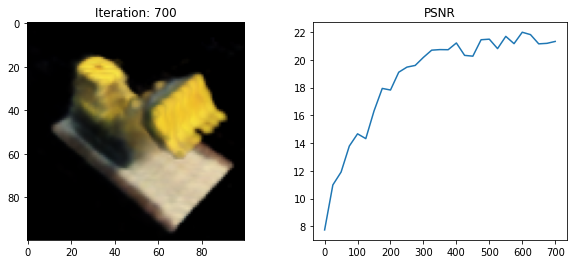

725 0.7210705089569092 secs per iter


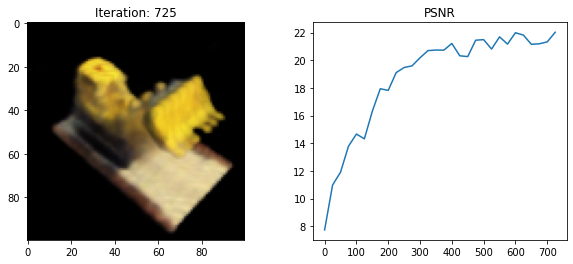

750 0.7187928867340088 secs per iter


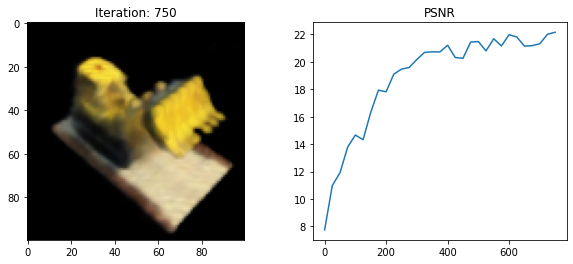

775 0.7198062992095947 secs per iter


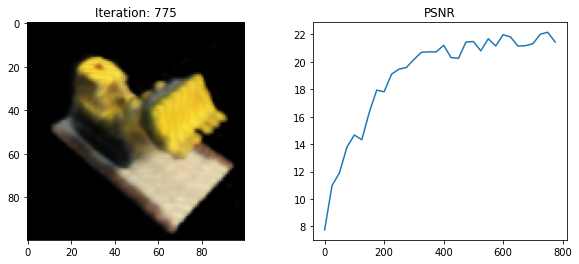

800 0.7193443965911865 secs per iter


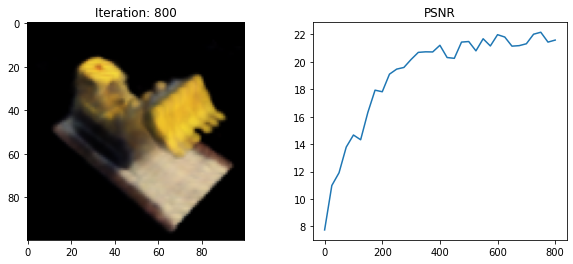

825 0.7194437789916992 secs per iter


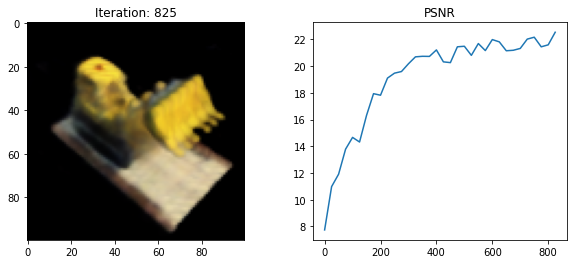

850 0.7205593109130859 secs per iter


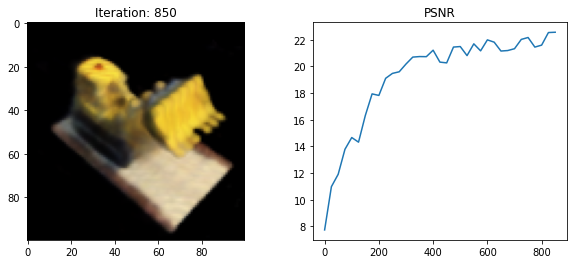

875 0.7176668262481689 secs per iter


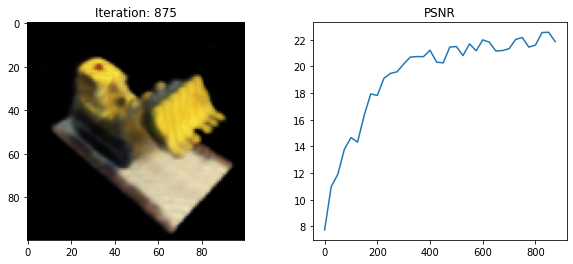

900 0.7189918804168701 secs per iter


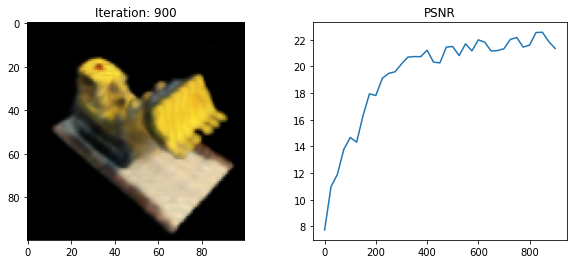

925 0.7181329059600831 secs per iter


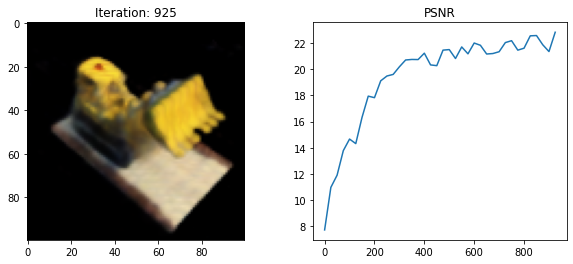

950 0.7191029357910156 secs per iter


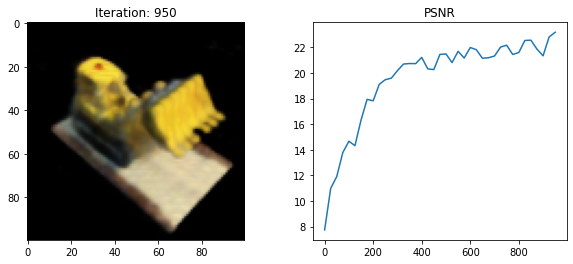

975 0.7208788681030274 secs per iter


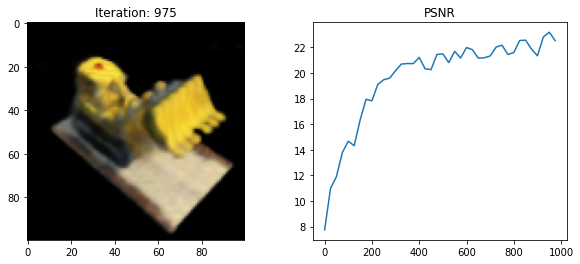

1000 0.7197797107696533 secs per iter


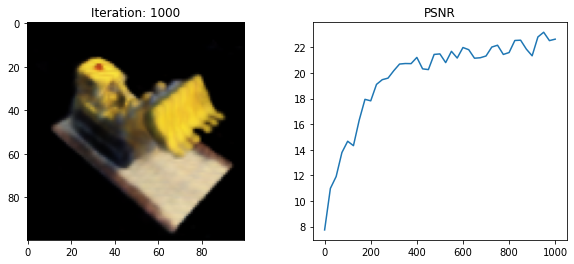

Done


In [5]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 64
N_iters = 1000
psnrs = []
iternums = []
i_plot = 25

import time
t = time.time()
for i in range(N_iters+1):
    
    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if i%i_plot==0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()
        
        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)
        
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')

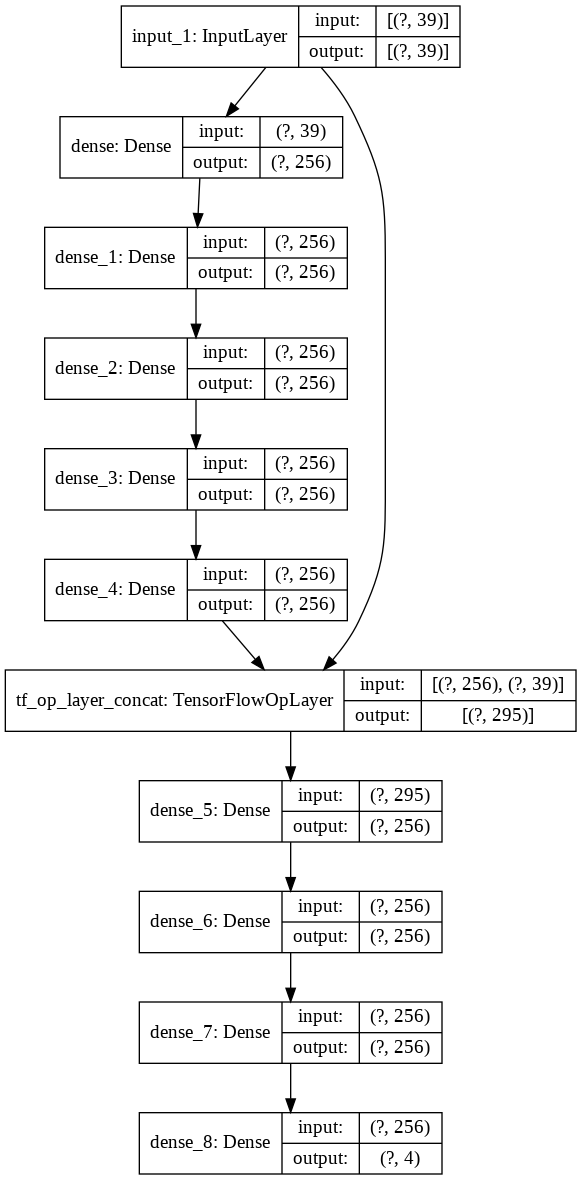

In [10]:
# plot the model structure
#model.summary()
from  tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

# Interactive Visualization

In [11]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb,0,1)
    
    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()
    

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

In [12]:
model.save("tiny_nerf.h5")
!ls -al *.h5

-rw-r--r-- 1 root root 1965736 Jan 19 04:35 tiny_nerf.h5


# Render 360 Video

In [ ]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)